In [2]:
import numpy as np
from numpy import ones
from numpy_sugar import ddot
# import os
# import sys
import pandas as pd
from pandas_plink import read_plink1_bin
from numpy.linalg import cholesky
from numpy_sugar.linalg import economic_svd
import xarray as xr
from struct_lmm2 import StructLMM2
from limix.qc import quantile_gaussianize
import matplotlib.pyplot as plt

In [3]:
import struct_lmm2 # check that it refers to code in repo
struct_lmm2

<module 'struct_lmm2' from '/hps/nobackup/stegle/users/acuomo/git_repos/struct-lmm2/struct_lmm2/__init__.py'>

In [4]:
chrom = 2

In [5]:
## this file will map cells to donors, it will also only including donors we have single cell data (a subset of all of HipSci donors)
sample_mapping_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/sample_mapping_file.tsv"
sample_mapping = pd.read_csv(sample_mapping_file, sep='\t', dtype={"genotype_individual_id": str, "phenotype_sample_id": str})

In [6]:
## extract unique individuals
donors = sample_mapping["genotype_individual_id"].unique()
donors.sort()
print("Number of unique donors: {}".format(len(donors)))

Number of unique donors: 126


In [7]:
## read in genotype file
plink_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.bed"
G = read_plink1_bin(plink_file)

Mapping files: 100%|██████████| 3/3 [06:27<00:00, 129.06s/it]


In [8]:
G.shape

(1610, 10464962)

In [9]:
## read in GRM kinship matrix
kinship_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink-F/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.kinship"
K = pd.read_csv(kinship_file, sep="\t", index_col=0)
assert all(K.columns == K.index)

In [10]:
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 125


In [11]:
## subset to relevant donors
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

In [12]:
## and decompose such as K = L @ L.T
L_kinship = cholesky(K.values)
L_kinship = xr.DataArray(L_kinship, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(L_kinship.sample.values == K.sample_0.values)

In [13]:
np.allclose(K.values, L_kinship.values @ L_kinship.values.T)

True

In [14]:
del K
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 36044
Sample mapping number of rows AFTER intersection: 35751


In [15]:
# expand from donors to cells
L_expanded = L_kinship.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [16]:
# environments
# cells by MOFA factors (10)
E_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/mofa_logcounts_model_factors.csv"
E = pd.read_csv(E_file, index_col = 0)
E = xr.DataArray(E.values, dims=["cell", "pc"], coords={"cell": E.index.values, "pc": E.columns.values})
E = E.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(E.cell.values == sample_mapping["phenotype_sample_id"].values)

In [17]:
E.head()

<xarray.DataArray (cell: 5, pc: 5)>
array([[-0.54978801,  1.11583786,  0.09235695,  1.40225012,  0.64556476],
       [ 0.26934134,  2.19734218,  0.70375016,  0.93139237, -0.33624749],
       [-0.02561868,  1.81561723, -0.07399272,  0.29092987,  0.06909543],
       [-0.69904249,  1.17026377,  0.17953677,  0.50106947,  1.54701071],
       [-0.22270389,  1.5511408 , -0.15298686,  0.26316878,  0.7975027 ]])
Coordinates:
  * cell     (cell) object '21843_1#10' '21843_1#100' ... '21843_1#103'
  * pc       (pc) object 'MOFA1' 'MOFA2' 'MOFA3' 'MOFA4' 'MOFA5'

In [18]:
G_sel = G.where(G.chrom == str(chrom), drop=True)
G_exp = G_sel.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == G_exp.sample.values)

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2542 times more chunks
  return self.array[key]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [19]:
# from 10,464,962 down to 903,871 variants
# same 1,610 individuals
G_sel.shape

(1610, 903871)

In [20]:
# expanded out to all 35,751 cells
G_exp.shape

(35751, 903871)

In [21]:
# get decomposition of K*EEt 
# i.e. get Li's such that K*EEt = L1L1t + L2L2t + ..
[U, S, _] = economic_svd(E)
del _

In [22]:
us = U * S
Ls = [ddot(us[:,i], L_expanded) for i in range(us.shape[1])]
del us

In [23]:
# Phenotype (single-cell gene expression)
# phenotype_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/exprs_alldays_allgenes.tsv"
# phenotype = pd.read_csv(phenotype_file, sep = "\t")

In [24]:
phenotype_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/exprs_alldays_allgenes.tsv.pkl"
phenotype = pd.read_pickle(phenotype_file)

In [25]:
print("Phenotype shape BEFORE selection: {}".format(phenotype.shape))

Phenotype shape BEFORE selection: (11231, 36044)


In [26]:
phenotype = xr.DataArray(phenotype.values, dims=["trait", "cell"], coords={"trait": phenotype.index.values, "cell": phenotype.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)
print("Phenotype shape AFTER selection: {}".format(phenotype.shape))
assert all(phenotype.cell.values == sample_mapping["phenotype_sample_id"].values)

Phenotype shape AFTER selection: (11231, 35751)


In [27]:
# Filter on specific gene-SNP pairs
# eQTL from endodiff (ips+mesendo+defendo)
endo_eqtl_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/eqtl_allstages.tsv"
endo_eqtl = pd.read_csv(endo_eqtl_file, sep="\t", index_col = False)
endo_eqtl["chrom"] = [int(i[:i.find("_")]) for i in endo_eqtl["snp_id"]]
genes = endo_eqtl[endo_eqtl['chrom']==int(chrom)]['feature'].unique()

In [28]:
len(genes)

230

In [29]:
# set up model
# starting with (fixed effect) covariates
n_samples = phenotype.shape[1]
M = ones((n_samples, 1))

In [ ]:
# column gaussianise environment(s)
E = quantile_gaussianize(E)

In [30]:
### PC1 only
n_factors = 1

In [198]:
i = 2
trait_name = genes[i]
trait_name

'ENSG00000144120_TMEM177'

In [199]:
y = phenotype.sel(trait=trait_name)

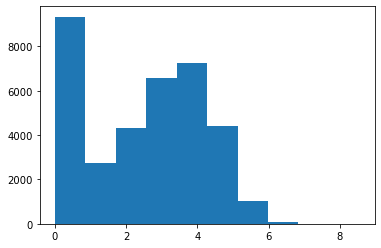

In [195]:
plt.hist(y)
plt.show()

In [196]:
y = quantile_gaussianize(y)

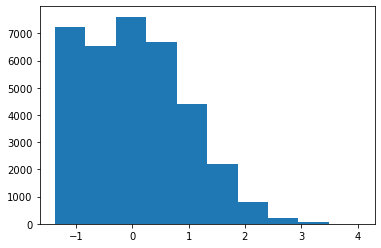

In [197]:
plt.hist(y)
plt.show()

In [150]:
# select SNPs
leads = endo_eqtl[endo_eqtl['feature']==trait_name]['snp_id'].unique()
leads

array(['2_170575157_G_A', '2_170617443_T_C', '2_170630637_A_G'],
      dtype=object)

In [151]:
G_tmp = G_exp[:,G_exp['snp'].isin(leads)]
G_tmp.shape

(35751, 3)

In [152]:
print("Running for gene {}".format(trait_name))
# null model
slmm2 = StructLMM2(y.values, M, E.values[:,0:n_factors], Ls)

Running for gene ENSG00000213160_KLHL23


In [153]:
ok = np.var(G_tmp.values, axis=0) > 0.0
pvals = np.full(G_tmp.shape[1], np.nan)

In [154]:
# interaction test
pvals[ok] = slmm2.scan_interaction(G_tmp[:, ok])[0]

100%|██████████| 3/3 [07:41<00:00, 153.90s/it]


In [155]:
pv = pd.DataFrame({"chrom":G_tmp.chrom.values,
    "pv":pvals,
    "variant":G_tmp.snp.values})

In [156]:
# ENSG00000213160_KLHL23
pv.head()

,chrom,pv,variant
0,2,0.759222,2_170575157_G_A
1,2,0.458122,2_170617443_T_C
2,2,0.580471,2_170630637_A_G


In [144]:
# ENSG00000240344_PPIL3
pv.head()

,chrom,pv,variant
0,2,0.318667,2_201742345_C_T
1,2,0.429637,2_201754063_T_C
2,2,0.981754,2_201774355_T_C


In [132]:
# ENSG00000136717_BIN1
pv.head()

,chrom,pv,variant
0,2,0.059557,2_127846505_T_C
1,2,0.047706,2_127859418_T_C
2,2,0.047706,2_127863029_C_T


In [120]:
# ENSG00000196208_GREB1
pv.head()

,chrom,pv,variant
0,2,0.434897,2_11720282_A_G
1,2,0.498994,2_11736305_G_A


In [108]:
# ENSG00000035141_FAM136A
pv.head()

,chrom,pv,variant
0,2,0.407267,2_70426325_C_T
1,2,0.201800,2_70502930_A_G
2,2,0.228603,2_70541419_A_G


In [96]:
# ENSG00000237651_C2orf74
pv.head()

,chrom,pv,variant
0,2,0.682125,2_61372507_A_G
1,2,0.810303,2_61381018_C_T
2,2,0.672080,2_61400816_G_A


In [84]:
# ENSG00000138032_PPM1B
pv.head()

,chrom,pv,variant
0,2,0.894768,2_44396235_T_G


In [72]:
# ENSG00000144120_TMEM177
pv.head()

,chrom,pv,variant
0,2,1.690871e-07,2_120438523_A_G


In [56]:
# ENSG00000183891_TTC32
pv.head()

,chrom,pv,variant
0,2,0.919268,2_20082172_T_C
1,2,0.655658,2_20090677_G_A


In [44]:
# ENSG00000229150_CRYGEP
pv.head()

,chrom,pv,variant
0,2,1.024255e-18,2_208977362_C_A
1,2,5.465857e-18,2_208977797_G_T


In [57]:
len(Ls)

10

In [58]:
Ls[0].shape

(35751, 125)

In [60]:
Ls[9].shape

(35751, 125)